# Plotting

In [2]:
from collections import Counter
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import pandas as pd
import random
random.seed(246810)
np.random.seed(246810)
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
eps = 1e-5  # a small number
# Vectorized function for hashing for np efficiency
def w(x):
    return np.int(hash(x)) % 1000

h = np.vectorize(w)


## 1. Set up final classifiers

In [4]:
# some scripts to merge the SW time and HW time + features CSV files
# no need to run again !!

# path_chstone= '../data/baseline_chstone.csv'
# chstone = pd.read_csv(path_chstone, delimiter=',')

# path_random = '../data/baseline_random.csv'
# random = pd.read_csv(path_random, delimiter=',')
# random.sort_values(by = ['program'])

# random_sw=pd.read_csv('../data/sw_perf_random.csv', delimiter=',')
# chstone_sw=pd.read_csv('../data/sw_perf_chstone.csv', delimiter=',')

# merged_random = random.merge(random_sw, left_on='program', right_on='program')
# merged_chstone = chstone.merge(chstone_sw, left_on='program', right_on='program')

# merged_random.to_csv('../data/final_random.csv', index=False)
# merged_chstone.to_csv('../data/final_chstone.csv',index=False)


In [5]:
dataset = "csmith_random_programs"
data = pd.read_csv('../data/final_random.csv', delimiter=',')
# set out training set to be 70% of total; 30% 
# random_idx = random.randint(0, np.shape(data)[0]) #27
num_train = round(np.shape(data)[0]*0.7)
train_data = data.values[0:num_train,:]
test_data =  data.values[num_train:, :]
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(data))

train_speedup = (train_data[:, -1] / train_data[:, 2]) # 
test_speedup = (test_data[:, -1] / test_data[:, 2]) # -O3
print(train_speedup)
# log_train_speedup = np.log10(train_speedup.astype(float))
# log_test_speedup = np.log10(test_speedup.astype(float))
# Get binary preduction output: is speedup (HW vs SW) > 2800 
y = (train_speedup > 2800).astype(int)
X = train_data[:,-57:-1]
y_test = (test_speedup > 2800).astype(int)
X_test = test_data[:,-57:-1]
print(np.count_nonzero(y) / len(y))
print(np.count_nonzero(y_test) / len(y_test))
assert(len(y) == np.shape(train_data)[0])
assert(len(y_test) == np.shape(test_data)[0] )

features = data.columns.values[-57:-1]
assert len(features) == 56
class_names = ["On-Chip", "Not On-Chip"]

(9011, 116)
(3862, 116)
(12873, 116)
[2915.27039334195 3064.5126890095776 3127.9902745113 ...
 2596.5991783791956 2804.3891404735623 3077.551395099053]
0.5433359227610698
0.5468669083376488


## Neural Net ##

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.fit_transform(X_test)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state = 0)

In [8]:

#defining dataset class
from torch.utils.data import Dataset, DataLoader
class trainData(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length
    
class testData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

    
trainset = trainData(X_train,y)
test_data = testData(torch.FloatTensor(X_test))
validation_data = testData(torch.FloatTensor(X_val))

train_loader = DataLoader(trainset,batch_size=64,shuffle=False)
test_loader = DataLoader(test_data,batch_size=1,shuffle=False)
validation_loader = DataLoader(validation_data,batch_size=1,shuffle=False)

In [9]:
class Net(nn.Module):
    def __init__(self,input_shape,width = 64, depth = 3, activation = torch.relu):
        super(Net,self).__init__()
        self.width = width
        self.depth = depth
        self.activation = activation
        self.layers = nn.ModuleList([])
        self.layers.append(nn.Linear(input_shape,self.width))
        for _ in range(1,self.depth-1):
            self.layers.append(nn.Linear(width,self.width))
        self.layers.append(nn.Linear(self.width,1))
        
    def forward(self,x):
        for i in range(0,self.depth-1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [11]:
epochs = 500
lr_ = 0.001

def binary_acc(y_pred, y_test):
    """Helper function for getting the accuracy of a batch."""
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

def train_model(model):
    """Train a model with the specified dimensions and activation fn."""
    optimizer = torch.optim.SGD(model.parameters(),lr=lr_)
    # Combines sigmoid and BCE in one class
    loss_fn = nn.BCEWithLogitsLoss()
    model.train()
    for e in range(1, epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = loss_fn(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss/len(train_loader), epoch_acc/len(train_loader)
        
def evaluate_model(model, test_loader, y_test):
    """Return the accuracy on a test or validation set"""
    y_pred_list = []
    model.eval()
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    return np.mean(y_pred_list == y_test)

In [12]:
# Include the validation set for training final model
X_train = np.concatenate((X_train, X_val))
y_train = np.concatenate((y, y_val))
trainset = trainData(X_train,y_train)
train_loader = DataLoader(trainset,batch_size=64,shuffle=False)

In [13]:
# Train best model
width = 32
depth = 2
activation = torch.relu
model = Net(input_shape=X_train.shape[1],width = width, depth = depth, activation = activation)
model.to(device)
train_model(model)

(0.5111299918757545, 77.24561403508773)

In [14]:
y_pred_list = []
mlp_roc = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        mlp_roc.append(y_test_pred.cpu().numpy())
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
mlp_roc = [a.squeeze().tolist() for a in mlp_roc]

              precision    recall  f1-score   support

           0      0.813     0.622     0.705       881
           1      0.735     0.880     0.801      1050

    accuracy                          0.762      1931
   macro avg      0.774     0.751     0.753      1931
weighted avg      0.771     0.762     0.757      1931

[[548 333]
 [126 924]]
Accuracy:
0.7622993267736924


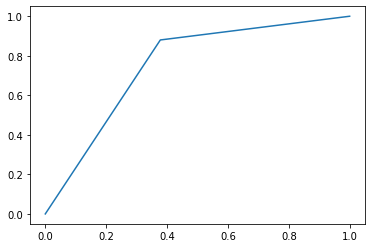

In [15]:
mlp_fpr, mlp_tpr, mlp_thresholds = roc_curve(y_test, y_pred_list)
plt.plot(mlp_fpr, mlp_tpr, label='MLP')
mlp_auc = roc_auc_score(y_test, y_pred_list)

print(classification_report(y_test, y_pred_list, digits=3))
print(confusion_matrix(y_test,y_pred_list))
print("Accuracy:")
print(np.mean(y_pred_list == y_test))

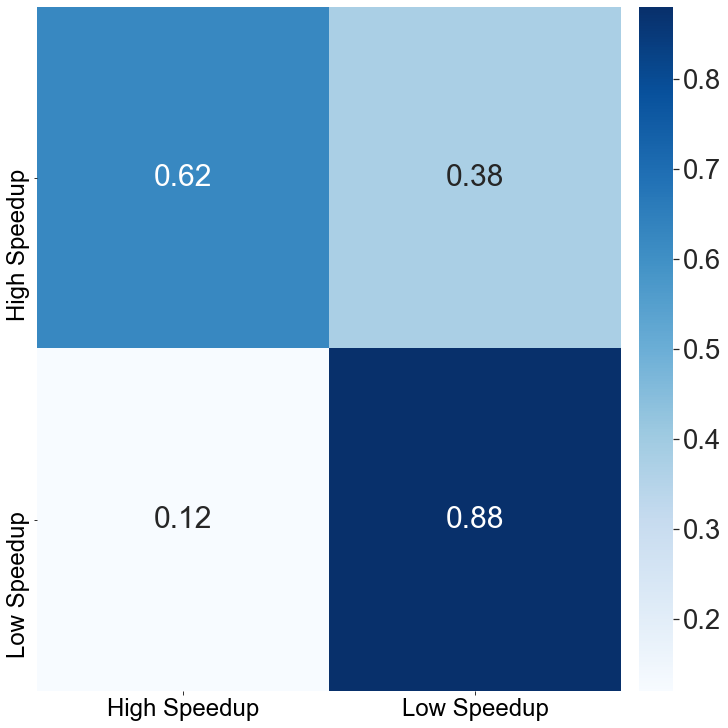

In [16]:
confusion_matrices = [('Neural Net', confusion_matrix(y_test,y_pred_list, normalize='true')),
                     ]
for name, matrix in confusion_matrices: 
    df_cm = pd.DataFrame(matrix, index = ['High Speedup', 'Low Speedup'],
                  columns = ['High Speedup', 'Low Speedup'])
    fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1, constrained_layout=True)
    sns.set(font_scale=2.5)
    ax = sns.heatmap(df_cm, annot=True, cmap="Blues")
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 24)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 24)
    fig.savefig('confusion_{}.pdf'.format(name))

In [17]:
# Parition Dataset-> Train : Test = 85 : 15 (for non-NN), Train : Val : Test = 70:15:15 for NN
# for non-NN, we use 3-fold cross validation (using sklearn crossvalscore)

num_train = round(np.shape(data)[0]*0.7)
train_data = data.values[0:num_train,:]
test_data =  data.values[num_train:, :]
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state = 0, shuffle=False)
train_data = np.concatenate((train_data, val_data), axis=0)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(data))

train_speedup = (train_data[:, -1] / train_data[:, 2]) # 
test_speedup = (test_data[:, -1] / test_data[:, 2]) # -O3

# Get binary speedup prediction output: Is speedup from HW acceleration > 2800x ?
y = (train_speedup > 2800).astype(int)
X = train_data[:,-57:-1] # -O3 features
y_test = (test_speedup > 2800).astype(int)
X_test = test_data[:,-57:-1] # -O3 features
print(np.count_nonzero(y) / len(y))
print(np.count_nonzero(y_test) / len(y_test))
assert(len(y) == np.shape(train_data)[0])
assert(len(y_test) == np.shape(test_data)[0] )

features = data.columns.values[-57:-1]
assert len(features) == 56
class_names = ["On-Chip", "Not On-Chip"]

(10942, 116)
(1931, 116)
(12873, 116)
0.5449643575214769
0.541170378042465


In [18]:
# Other classifiers
rf = RandomForestClassifier(bootstrap=True,max_depth=10, min_samples_leaf=25, min_samples_split= 4, n_estimators=450, max_features='sqrt')
rf.fit(X,y)
print(rf.score(X_test, y_test))

0.7674779906784049


In [19]:
logreg = make_pipeline(StandardScaler(), LogisticRegression(C=0.01, penalty='l2'))
logreg.fit(X,y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.01))])

In [20]:
svm = make_pipeline(StandardScaler(), SVC(gamma=0.01, C=1, kernel='rbf'))
svm.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, gamma=0.01))])

In [21]:
ada = AdaBoostClassifier(n_estimators=600, learning_rate=0.1).fit(X,y)

In [22]:
gbm = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=5, subsample=0.5).fit(X,y)

In [23]:
#Confusion Matrix Visulization

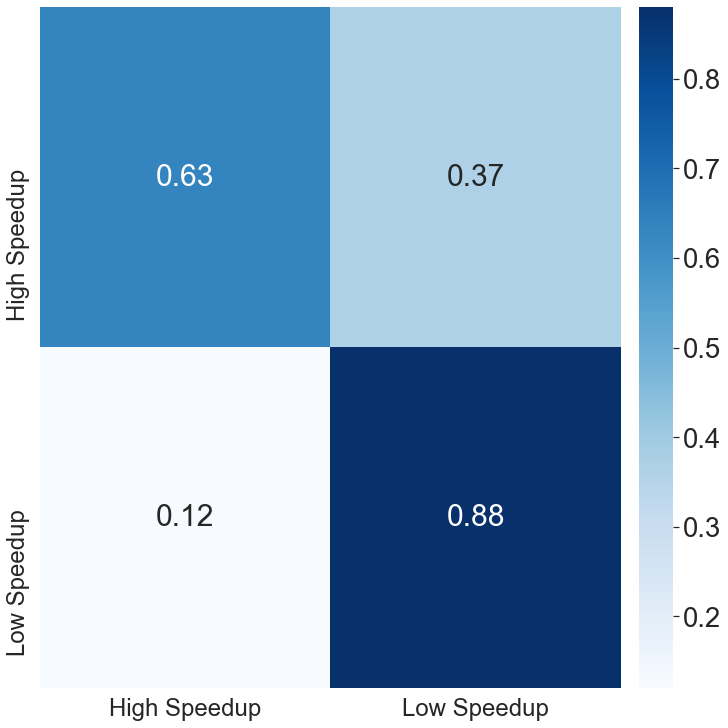

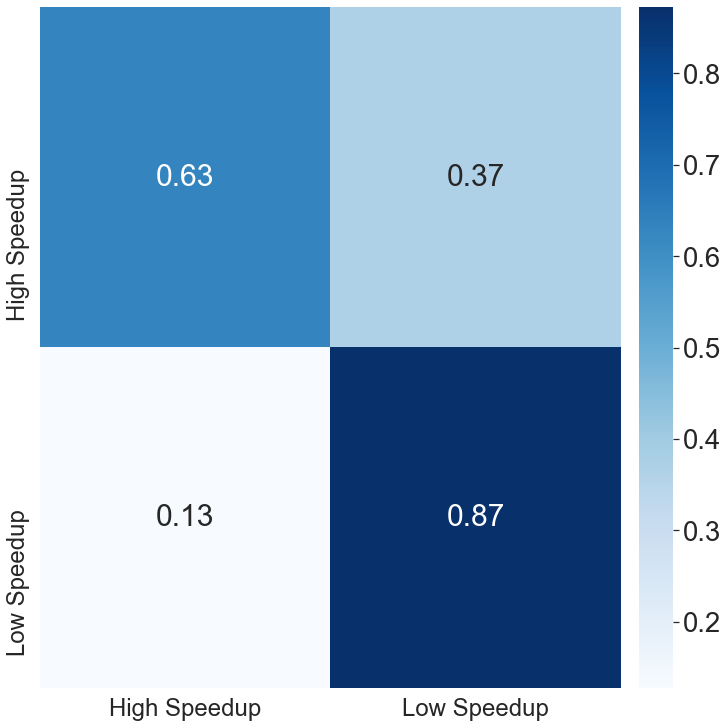

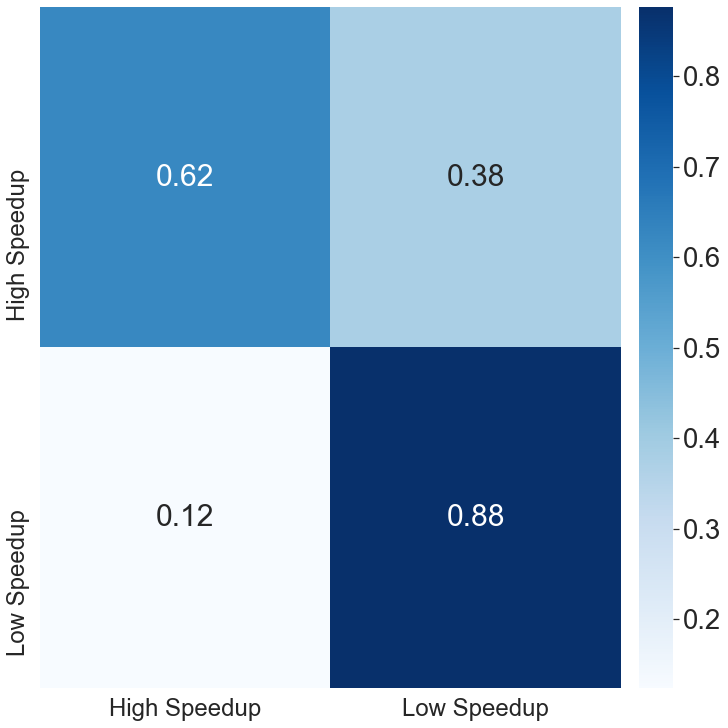

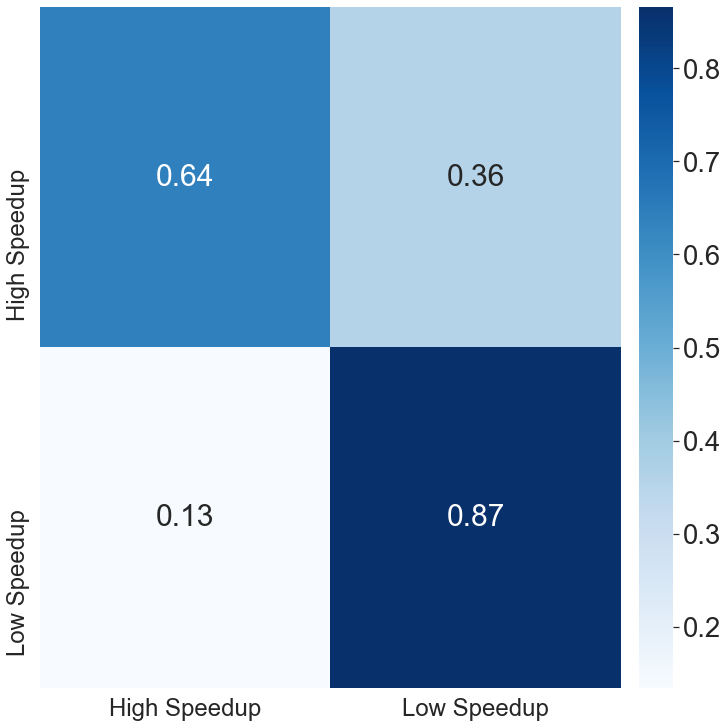

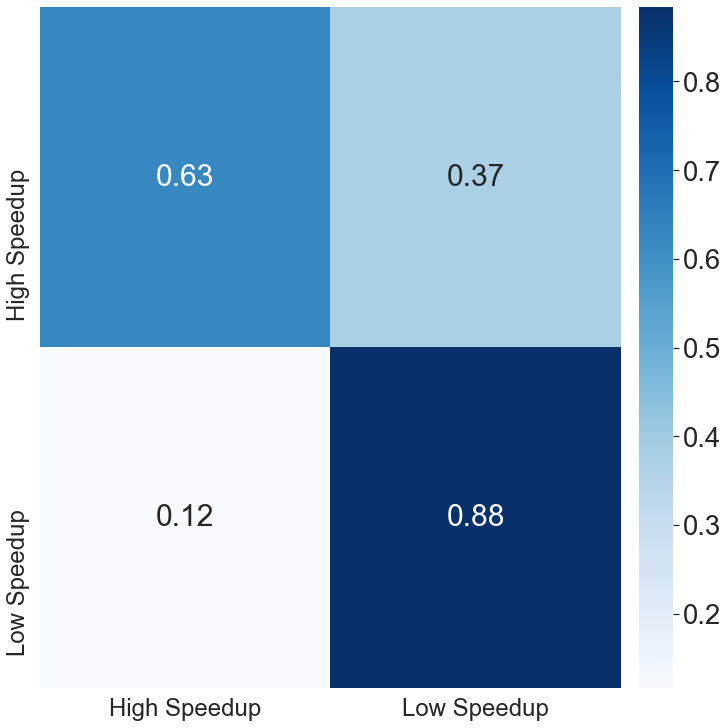

In [24]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion_matrices = [
                      ('Random Forest', confusion_matrix(y_test, rf.predict(X_test), normalize='true')),
                      ('Logistic Regression', confusion_matrix(y_test, logreg.predict(X_test), normalize='true')),
                      ('Support Vector Machine', confusion_matrix(y_test, svm.predict(X_test), normalize='true')),
                      ('AdaBoost', confusion_matrix(y_test, ada.predict(X_test), normalize='true')),
                      ('Gradient Boosting', confusion_matrix(y_test, gbm.predict(X_test), normalize='true')),
                     ]
for name, matrix in confusion_matrices: 
    df_cm = pd.DataFrame(matrix, index = ['High Speedup', 'Low Speedup'],
                  columns = ['High Speedup', 'Low Speedup'])
    fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1, constrained_layout=True)
    sns.set(font_scale=2.5)
    ax = sn.heatmap(df_cm, annot=True, cmap="Blues")
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 24)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 24)
    fig.savefig('confusion_{}.pdf'.format(name))

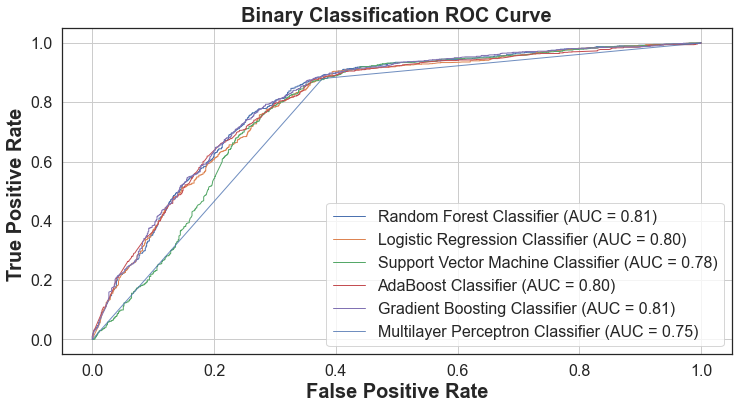

In [25]:
from sklearn.metrics import plot_roc_curve, auc, roc_curve, roc_auc_score

fontsize=20
sns.set_style("white")

# #############################################################################
models = [
                      ('Random Forest',rf),
                      ('Logistic Regression',logreg),
                      ('Support Vector Machine', svm),
                      ('AdaBoost', ada),
                      ('Gradient Boosting', gbm),
                     ]
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(12,6),nrows=1, ncols=1, constrained_layout=False)
for i, classifier in models:
    viz = plot_roc_curve(classifier, X_test, y_test,
                         name='{} Classifier'.format(i),
                         alpha=1, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)

# mean_tpr = np.mean(tprs, axis=0)
# mean_tpr[-1] = 1.0
# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)

ax.plot(mlp_fpr, mlp_tpr, color='b',
       label="Multilayer Perceptron Classifier (AUC = {})".format(np.round(mlp_auc,2)),
       lw=1, alpha=.8)

# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                 label=r'$\pm$ 1 std. dev.')

ax.set_ylabel("True Positive Rate ", fontsize=fontsize, weight='bold')
ax.set_xlabel("False Positive Rate", fontsize=fontsize, weight='bold')
ax.tick_params(axis='x', labelsize=fontsize*0.8) # change the fontsize for xticks label (for all layers)
ax.tick_params(axis='y', labelsize=fontsize*0.8) # change the fontsize for xticks label (for all layers)

ax.yaxis.grid()
ax.xaxis.grid()

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],)
ax.set_title("Binary Classification ROC Curve", fontsize=fontsize, weight='bold')
ax.legend(loc="lower right", fontsize=fontsize*0.8)
plt.show()
fig.savefig('roc.pdf')

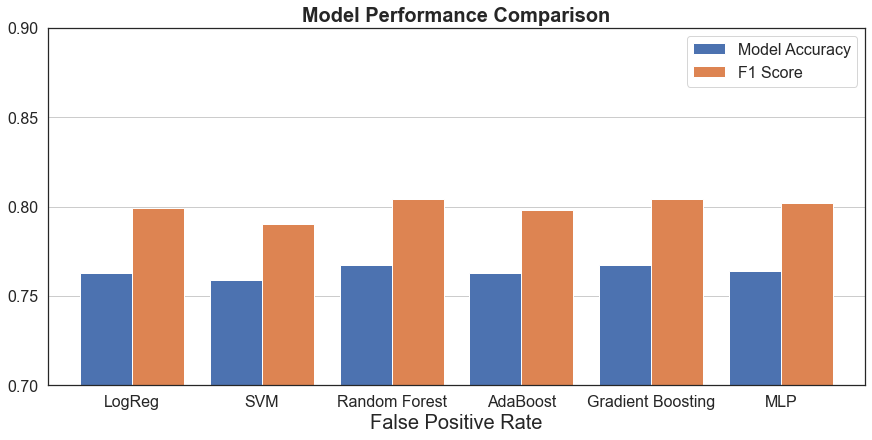

In [26]:
fontsize=20
sns.set_style("white")

models = [             
                      ('LogReg',logreg),
                      ('SVM', svm),
    ('Random Forest',rf),
                      ('AdaBoost', ada),
                      ('Gradient Boosting', gbm),
                      ('MLP', model),
                     ]
model_list=[]
for name, clf in models:
    model_list.append(name)
accuracy = [0.763, 0.759, .767, 0.763, 0.767,0.764]
f1 = [0.799, 0.79, 0.804, 0.798, 0.804, 0.802]  
combined = {"Model Accuracy": accuracy, "F1 Score":f1}
df = pd.DataFrame(combined, index = model_list)

fig, ax = plt.subplots(figsize=(12,6),nrows=1, ncols=1, constrained_layout=True)
ax = df.plot.bar(ax=ax, rot=0, fontsize=fontsize*0.8, width=0.8, stacked=False)
ax.set_ylabel("", fontsize=fontsize)
ax.set_xlabel("False Positive Rate", fontsize=fontsize)
ax.yaxis.grid()

ax.set(ylim=[0.7, 0.9])
ax.set_title("Model Performance Comparison", fontsize=fontsize, weight='bold')
ax.legend(loc="upper right", fontsize=fontsize*0.8)


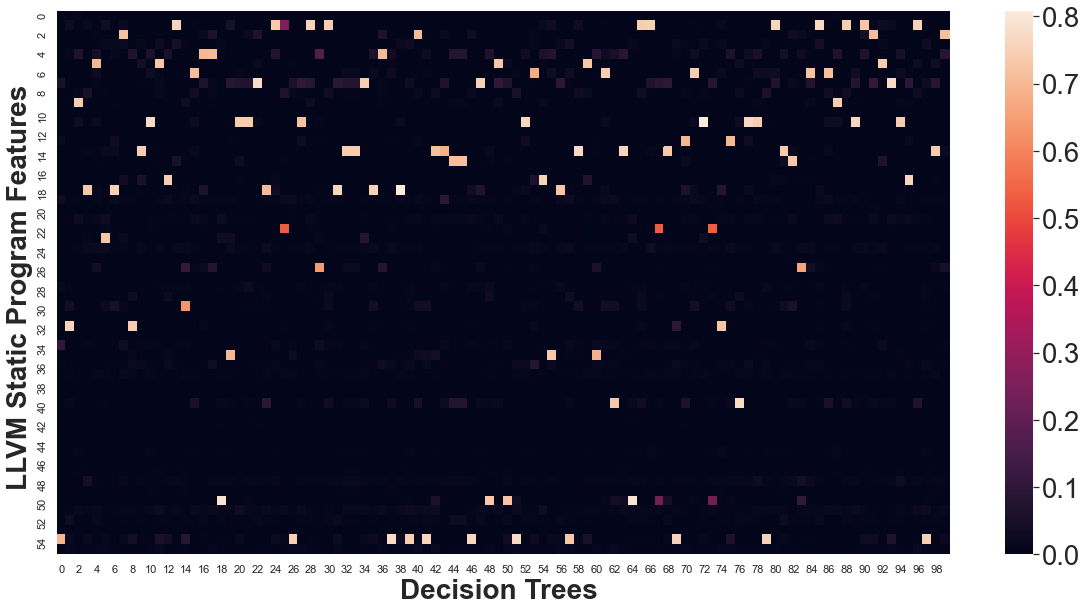

In [27]:
import seaborn as sns; sns.set_theme()
# plt.style.use('white_background')

trees = rf.estimators_
imp = np.zeros((56,100))
tree_indices = np.random.choice(range(450),100)
for i in range(100):
    imp[:,i] = trees[tree_indices[i]].feature_importances_
fig, ax = plt.subplots(figsize=(20,10),nrows=1, ncols=1, constrained_layout=False)
sns.set(font_scale=2.5)
ax = sns.heatmap(imp, annot=False, cmap="rocket")
ax.set_ylabel("LLVM Static Program Features ", fontsize=28, weight='bold' )
ax.set_xlabel("Decision Trees ", fontsize=28, weight='bold')

fig.savefig('random_forest_heatmap.pdf')
fig.show()

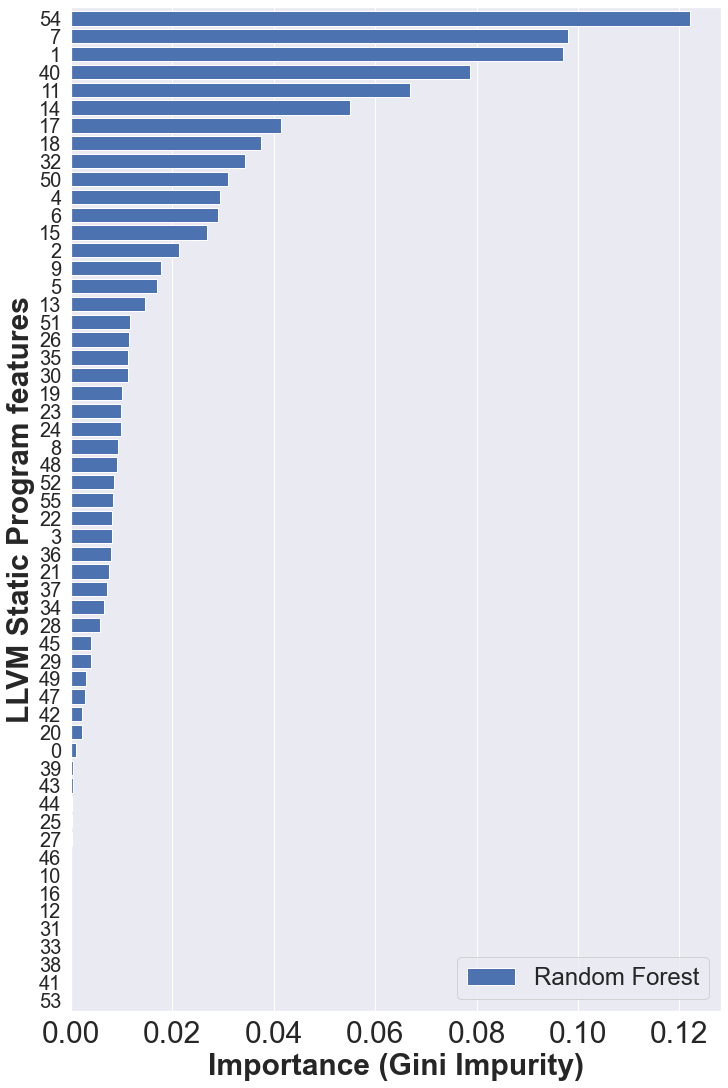

In [28]:
fontsize=30
# sns.set_style("darkgrid")
# plt.style.use('dark_background')

imps = {'Random Forest':rf.feature_importances_ }
df = pd.DataFrame(imps).sort_values(by='Random Forest')
fig, ax = plt.subplots(figsize=(10,15),nrows=1, ncols=1, constrained_layout=True)

ax = df.plot.barh(ax=ax, rot=0, fontsize=fontsize, width=0.8, stacked=False, color='b')
ax.set_xlabel("Importance (Gini Impurity)", fontsize=fontsize, weight='bold')
ax.set_ylabel("LLVM Static Program features", fontsize=fontsize, weight='bold')
ax.yaxis.grid()
ax.tick_params(axis='y', labelsize=20) # change the fontsize for xticks label (for all layers)

# ax.set(ylim=[0.7, 0.9])
#ax.set_title("Feature Importances", fontsize=fontsize, weight='bold')
ax.legend(loc="lower right", fontsize=fontsize*0.8)
fig.savefig('rf_importances.pdf')
fig.show()

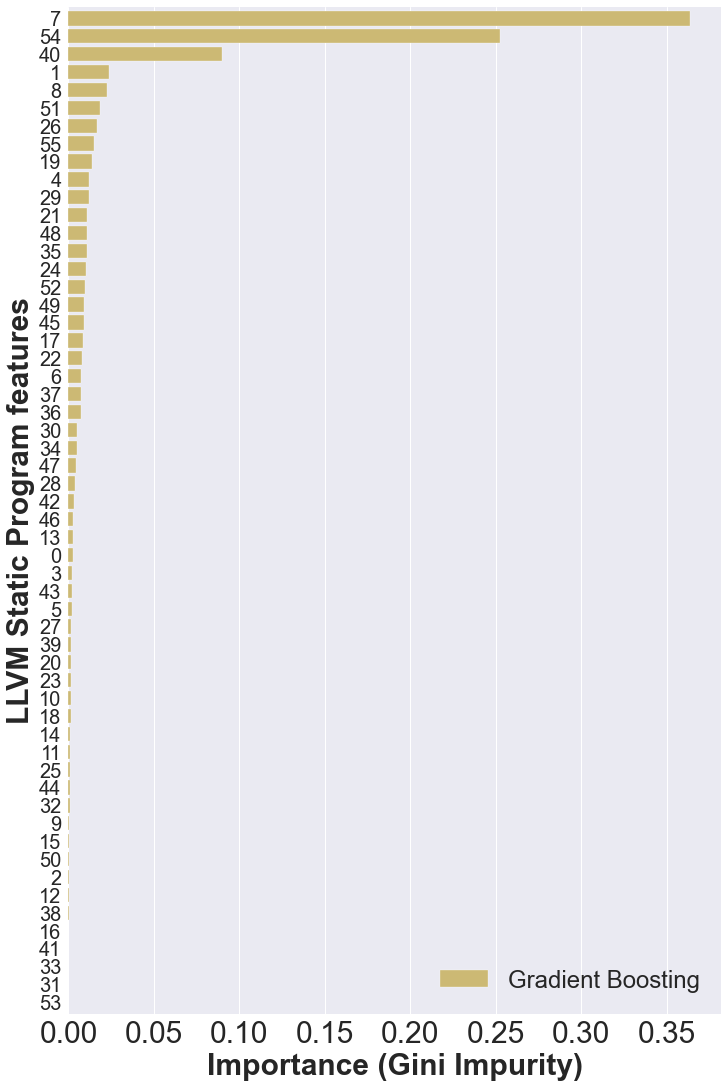

In [29]:
fontsize=30
# sns.set_style("darkgrid")
# plt.style.use('dark_background')
plt.style.use('seaborn')

imps = {'Gradient Boosting' : gbm.feature_importances_ }
df = pd.DataFrame(imps).sort_values(by='Gradient Boosting')
fig, ax = plt.subplots(figsize=(10,15),nrows=1, ncols=1, constrained_layout=True)

ax = df.plot.barh(ax=ax, rot=0, fontsize=fontsize, width=0.8, stacked=False, color='y')
ax.set_xlabel("Importance (Gini Impurity)", fontsize=fontsize, weight='bold')
ax.set_ylabel("LLVM Static Program features", fontsize=fontsize, weight='bold')
ax.yaxis.grid()
ax.tick_params(axis='y', labelsize=20) # change the fontsize for xticks label (for all layers)

# ax.set(ylim=[0.7, 0.9])
#ax.set_title("Feature Importances", fontsize=fontsize, weight='bold')
ax.legend(loc="lower right", fontsize=fontsize*0.8)
fig.savefig('gbm_importances.pdf')
fig.show()